In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# This line makes plots appear inline in the notebook
%matplotlib inline

In [17]:
# Grid dimensions
WIDTH = 20 #162
HEIGHT = 20 #130
G = nx.DiGraph()

# 1. Create all grid nodes.
#    Nodes at even x and y are "populated" (with subtype 'big' or 'small').
#    All others are "bus" nodes (serving as interconnects).
for x in range(WIDTH):
    for y in range(HEIGHT):
        if x % 2 == 0 and y % 2 == 0:
            # Populated node
            # Determine subtype using (x//2 + y//2) mod 2
            subtype = 'big' if ((x//2 + y//2) % 2 == 0) else 'small'
            G.add_node((x, y), type='populated', subtype=subtype, pos=(x, y))
        else:
            # Bus node (just for interconnection)
            G.add_node((x, y), type='bus', pos=(x, y))

# 2. For every "big" populated node, add its connections via bus nodes.
#    Connections are now split into two hops: populated -> bus -> populated.
for x in range(0, WIDTH, 2):
    for y in range(0, HEIGHT, 2):
        node = (x, y)
        # Only process populated nodes that are "big"
        if G.nodes[node].get('subtype') != 'big':
            continue

        # -- Input edges: Intended from six populated neighbors (2 steps away)
        input_offsets = [(-2, -2), (0, -2), (2, -2),
                         (-2,  2), (0,  2), (2,  2)]
        for dx, dy in input_offsets:
            src = (x + dx, y + dy)
            # Check source exists, is within bounds, and is populated
            if (0 <= src[0] < WIDTH and 0 <= src[1] < HEIGHT and 
                src in G and G.nodes[src].get('type') == 'populated'):
                # Determine the intermediate bus node (exactly halfway)
                bus = (x + dx//2, y + dy//2)
                if bus in G:
                    # Chain: source populated -> bus -> this big node.
                    G.add_edge(src, bus, role='input_bus')
                    G.add_edge(bus, node, role='input')

        # -- Output edges: To four cardinal neighboring populated nodes (2 steps away)
        output_offsets = [(0, -2), (2, 0), (0, 2), (-2, 0)]
        for dx, dy in output_offsets:
            dst = (x + dx, y + dy)
            if (0 <= dst[0] < WIDTH and 0 <= dst[1] < HEIGHT and 
                dst in G and G.nodes[dst].get('type') == 'populated'):
                bus = (x + dx//2, y + dy//2)
                if bus in G:
                    # Chain: this big node -> bus -> destination populated.
                    G.add_edge(node, bus, role='output_bus')
                    G.add_edge(bus, dst, role='output')

        # -- Diagonal connections along the SW–NE direction:
        diagonal_offsets = [(2, -2), (-2, 2)]
        for dx, dy in diagonal_offsets:
            dst = (x + dx, y + dy)
            if (0 <= dst[0] < WIDTH and 0 <= dst[1] < HEIGHT and 
                dst in G and G.nodes[dst].get('type') == 'populated'):
                bus = (x + dx//2, y + dy//2)
                if bus in G:
                    G.add_edge(node, bus, role='diagonal_bus')
                    G.add_edge(bus, dst, role='diagonal')

print("Graph created with {} nodes and {} edges.".format(
    G.number_of_nodes(), G.number_of_edges()))

Graph created with 400 nodes and 864 edges.


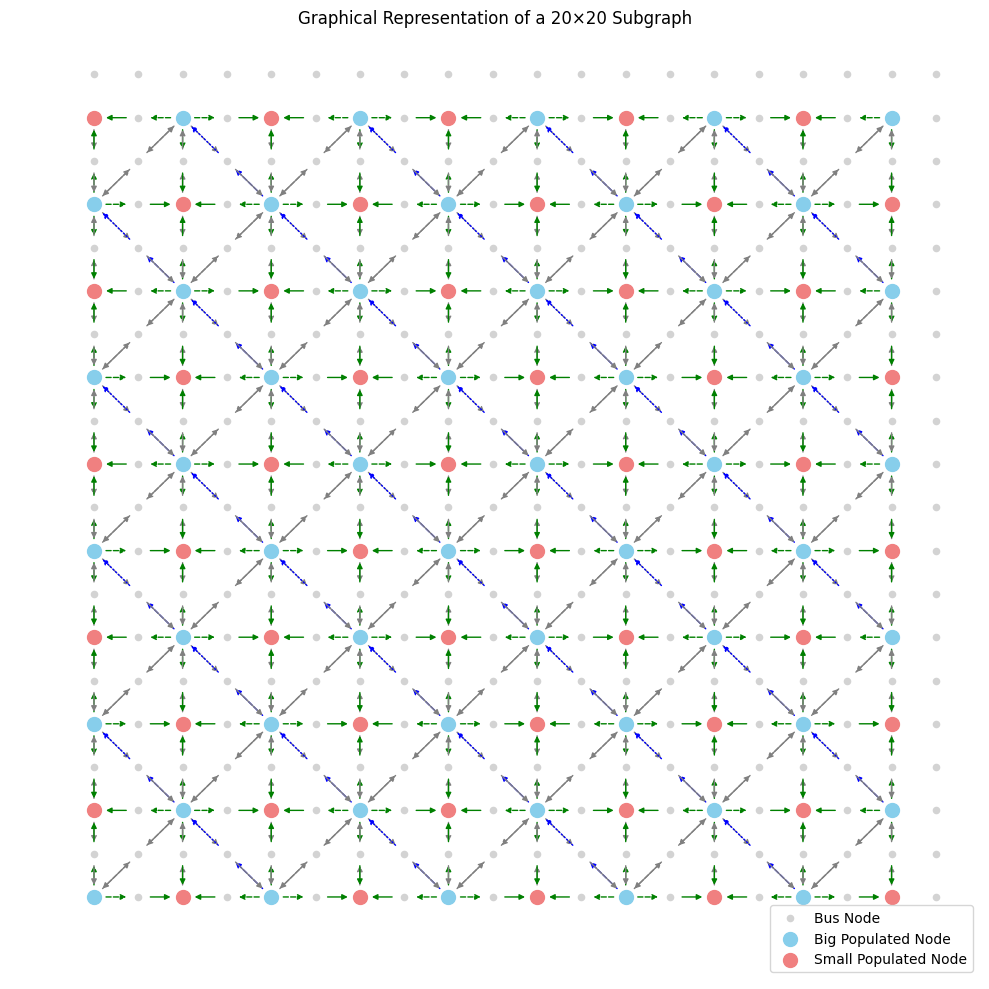

In [18]:
# Retrieve node positions
pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 10))

# Separate nodes by type:
# - Populated nodes with subtype 'big'
big_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'populated' and d.get('subtype') == 'big']
# - Populated nodes with subtype 'small'
small_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'populated' and d.get('subtype') == 'small']
# - Bus nodes (the interconnects)
bus_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'bus']

# Draw the nodes:
nx.draw_networkx_nodes(G, pos, nodelist=bus_nodes, node_color='lightgray', node_size=20, label='Bus Node')
nx.draw_networkx_nodes(G, pos, nodelist=big_nodes, node_color='skyblue', node_size=100, label='Big Populated Node')
nx.draw_networkx_nodes(G, pos, nodelist=small_nodes, node_color='lightcoral', node_size=100, label='Small Populated Node')

# Collect edges by role:
# For each connection, we have two parts: one from a populated node to a bus node,
# and then from the bus node to the target populated node.
input_bus_edges    = [(u, v) for u, v, d in G.edges(data=True) if d.get('role') == 'input_bus']
input_edges        = [(u, v) for u, v, d in G.edges(data=True) if d.get('role') == 'input']
output_bus_edges   = [(u, v) for u, v, d in G.edges(data=True) if d.get('role') == 'output_bus']
output_edges       = [(u, v) for u, v, d in G.edges(data=True) if d.get('role') == 'output']
diagonal_bus_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('role') == 'diagonal_bus']
diagonal_edges     = [(u, v) for u, v, d in G.edges(data=True) if d.get('role') == 'diagonal']

# Draw bus segments (dashed lines)
nx.draw_networkx_edges(G, pos, edgelist=input_bus_edges, edge_color='gray', style='dashed', arrowsize=8, label='Input Bus')
nx.draw_networkx_edges(G, pos, edgelist=output_bus_edges, edge_color='green', style='dashed', arrowsize=8, label='Output Bus')
nx.draw_networkx_edges(G, pos, edgelist=diagonal_bus_edges, edge_color='blue', style='dashed', arrowsize=8, label='Diagonal Bus')

# Draw final connection segments (solid or dotted lines)
nx.draw_networkx_edges(G, pos, edgelist=input_edges, edge_color='gray', arrowsize=8, label='Input')
nx.draw_networkx_edges(G, pos, edgelist=output_edges, edge_color='green', arrowsize=8, label='Output')
nx.draw_networkx_edges(G, pos, edgelist=diagonal_edges, edge_color='blue', style='dotted', arrowsize=8, label='Diagonal')

plt.title('Graphical Representation of a 20×20 Subgraph')
plt.legend(scatterpoints=1)
plt.axis('off')
plt.tight_layout()
plt.show()
